In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0, MobileNetV2
from sklearn.metrics import confusion_matrix

In [ ]:
# Classification dataset
CLASS_DATA_DIR = '/content/drive/MyDrive/BrainTumor'

# Segmentation dataset
SEG_DATA_DIR = '/content/drive/MyDrive/BrainTumor/BrainTumorSegmentation'
IMG_DIR  = SEG_DATA_DIR + '/images'
MASK_DIR = SEG_DATA_DIR + '/masks'

In [ ]:
print("Training classes :", os.listdir(CLASS_DATA_DIR + '/Training'))
print("Testing classes  :", os.listdir(CLASS_DATA_DIR + '/Testing'))
print("Seg images count :", len(os.listdir(IMG_DIR)))
print("Seg masks count  :", len(os.listdir(MASK_DIR)))

Training classes : ['glioma_tumor', 'pituitary_tumor', 'no_tumor', 'meningioma_tumor']
Testing classes  : ['pituitary_tumor', 'no_tumor', 'glioma_tumor', 'meningioma_tumor']
Seg images count : 3079
Seg masks count  : 3077


In [ ]:
datagen = ImageDataGenerator(rescale=1./255)

train_data = datagen.flow_from_directory(
    CLASS_DATA_DIR + '/Training',
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)

test_data = datagen.flow_from_directory(
    CLASS_DATA_DIR + '/Testing',
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 2875 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [ ]:
def attention_block(x):
    gap = layers.GlobalAveragePooling2D()(x)
    dense1 = layers.Dense(x.shape[-1] // 8, activation='relu')(gap)
    dense2 = layers.Dense(x.shape[-1], activation='sigmoid')(dense1)
    scale = layers.Reshape((1,1,x.shape[-1]))(dense2)
    return layers.multiply([x, scale])

In [ ]:
eff_base = EfficientNetV2B0(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)
eff_base.trainable = False

x = attention_block(eff_base.output)
x = layers.GlobalAveragePooling2D()(x)
eff_out = layers.Dense(4, activation='softmax')(x)

eff_model = models.Model(eff_base.input, eff_out)
eff_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
mob_base = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)
mob_base.trainable = False

x = attention_block(mob_base.output)
x = layers.GlobalAveragePooling2D()(x)
mob_out = layers.Dense(4, activation='softmax')(x)

mob_model = models.Model(mob_base.input, mob_out)
mob_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
eff_model.fit(train_data, epochs=10, validation_data=test_data)
mob_model.fit(train_data, epochs=10, validation_data=test_data)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 693s 4s/step - accuracy: 0.2966 - loss: 1.3614 - val_accuracy: 0.2538 - val_loss: 1.4443
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 119s 659ms/step - accuracy: 0.3082 - loss: 1.3536 - val_accuracy: 0.1878 - val_loss: 1.4879
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 118s 655ms/step - accuracy: 0.3048 - loss: 1.3475 - val_accuracy: 0.3198 - val_loss: 1.4781
Epoch 4/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 117s 649ms/step - accuracy: 0.3208 - loss: 1.3408 - val_accuracy: 0.1878 - val_loss: 1.5048
Epoch 5/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 126s 700ms/step - accuracy: 0.3049 - loss: 1.3351 - val_accuracy: 0.2919 - val_loss: 1.4353
Epoch 6/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 119s 659ms/step - accuracy: 0.3031 - loss: 1.3391 - val_accuracy: 0.2310 - val_loss: 1.4762
Epoch 7/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 116s 643ms/step - accuracy: 0.2871 - loss: 1.3385 - val_accuracy: 0.1878 - val_loss: 1.5009
Epoch 8/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 121s 672ms/step - accuracy: 0.2934 - lo

In [ ]:
import numpy as np

# Predict probabilities
pred_eff = eff_model.predict(test_data, verbose=0)
pred_mob = mob_model.predict(test_data, verbose=0)

# Simple average ensemble
ensemble_pred = (pred_eff + pred_mob) / 2.0

# Final predicted labels
y_pred = np.argmax(ensemble_pred, axis=1)

# True labels
y_true = test_data.classes

class_names = list(test_data.class_indices.keys())
print("Classes:", class_names)

Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Confusion Matrix:
 [[ 24  50  21   5]
 [  0 114   1   0]
 [  0   0 105   0]
 [  0   4   6  64]]

Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.24      0.39       100
meningioma_tumor       0.68      0.99      0.81       115
        no_tumor       0.79      1.00      0.88       105
 pituitary_tumor       0.93      0.86      0.90        74

        accuracy                           0.78       394
       macro avg       0.85      0.77      0.74       394
    weighted avg       0.84      0.78      0.74       394



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

Confusion Matrix:
 [[ 24  50  21   5]
 [  0 114   1   0]
 [  0   0 105   0]
 [  0   4   6  64]]

Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.24      0.39       100
meningioma_tumor       0.68      0.99      0.81       115
        no_tumor       0.79      1.00      0.88       105
 pituitary_tumor       0.93      0.86      0.90        74

        accuracy                           0.78       394
       macro avg       0.85      0.77      0.74       394
    weighted avg       0.84      0.78      0.74       394



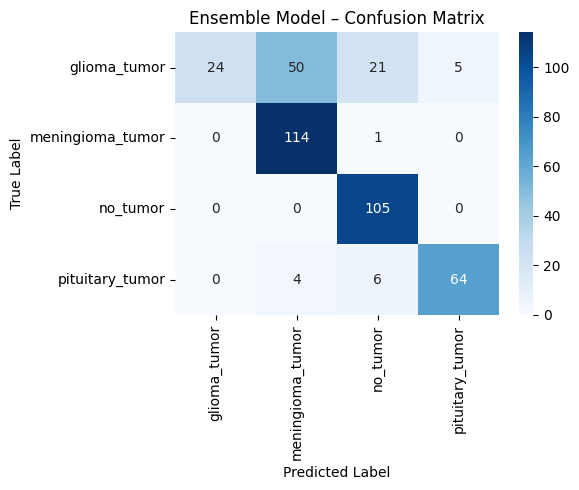

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Ensemble Model – Confusion Matrix")
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


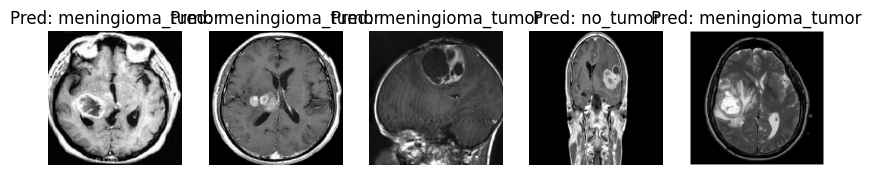

In [ ]:
img_batch, label_batch = next(test_data)

preds = np.argmax((eff_model.predict(img_batch) +
                   mob_model.predict(img_batch)) / 2, axis=1)

plt.figure(figsize=(10,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(img_batch[i])
    plt.title(f"Pred: {class_names[preds[i]]}")
    plt.axis('off')
plt.show()

In [ ]:
IMG_SIZE = 128        # ↓ reduces computation by 4×
BATCH_SIZE = 16
EPOCHS = 5            # fast demo training

In [ ]:
import tensorflow as tf
import os

IMG_DIR  = '/content/drive/MyDrive/BrainTumor/BrainTumorSegmentation/images'
MASK_DIR = '/content/drive/MyDrive/BrainTumor/BrainTumorSegmentation/masks'

img_files  = sorted(os.listdir(IMG_DIR))
mask_files = sorted(os.listdir(MASK_DIR))

common_files = list(set(img_files) & set(mask_files))

def load_image_mask(fname):
    img_path  = tf.strings.join([IMG_DIR, '/', fname])
    mask_path = tf.strings.join([MASK_DIR, '/', fname])

    img  = tf.io.read_file(img_path)
    mask = tf.io.read_file(mask_path)

    img  = tf.image.decode_png(img, channels=1)
    mask = tf.image.decode_png(mask, channels=1)

    img  = tf.image.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE)) / 255.0

    return img, mask


dataset = tf.data.Dataset.from_tensor_slices(common_files)
dataset = dataset.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(200).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Total segmentation samples:", len(common_files))

Total segmentation samples: 3064


In [ ]:
from tensorflow.keras import layers, models

def mini_unet(input_shape=(128,128,1)):
    inputs = layers.Input(input_shape)

    x = layers.Conv2D(16,3,activation='relu',padding='same')(inputs)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(32,3,activation='relu',padding='same')(x)
    x = layers.UpSampling2D()(x)

    outputs = layers.Conv2D(1,1,activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
unet = mini_unet()
unet.summary()

unet.fit(
    dataset,
    epochs=EPOCHS
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,833 (18.88 KB)

 Trainable params: 4,833 (18.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 117s 264ms/step - accuracy: 0.9803 - loss: 0.3114
Epoch 2/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 50s 249ms/step - accuracy: 0.9827 - loss: 0.0739
Epoch 3/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 81s 249ms/step - accuracy: 0.9826 - loss: 0.0725
Epoch 4/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 58s 292ms/step - accuracy: 0.9826 - loss: 0.0721
Epoch 5/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 49s 246ms/step - accuracy: 0.9826 - loss: 0.0715


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


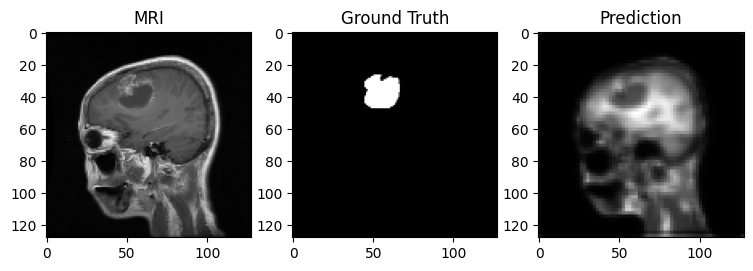

In [ ]:
import matplotlib.pyplot as plt

for img, mask in dataset.take(1):
    pred = unet.predict(img[:1])[0,:,:,0]

    plt.figure(figsize=(9,3))

    plt.subplot(1,3,1)
    plt.imshow(img[0].numpy().squeeze(), cmap='gray')
    plt.title("MRI")

    plt.subplot(1,3,2)
    plt.imshow(mask[0].numpy().squeeze(), cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(1,3,3)
    plt.imshow(pred, cmap='gray')
    plt.title("Prediction")

    plt.show()

In [ ]:
import tensorflow as tf
import numpy as np

@tf.function
def grad_cam_fast(model, img_tensor, last_conv_layer):
    grad_model = tf.keras.models.Model(
        model.inputs,
        [model.get_layer(last_conv_layer).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_tensor, training=False)
        class_idx = tf.argmax(preds[0])
        loss = preds[:, class_idx]

    grads = tape.gradient(loss, conv_out)
    weights = tf.reduce_mean(grads, axis=(0,1,2))
    cam = tf.reduce_sum(tf.multiply(weights, conv_out), axis=-1)

    cam = tf.nn.relu(cam)
    cam = cam / (tf.reduce_max(cam) + 1e-8)

    return cam

In [ ]:
def get_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None

last_conv_eff = get_last_conv_layer(eff_model)
print("EfficientNet last conv:", last_conv_eff)

EfficientNet last conv: top_conv


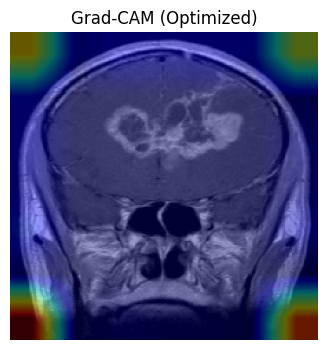

In [ ]:
import cv2
import matplotlib.pyplot as plt

img_batch, _ = next(test_data)
img = img_batch[0]
img_tensor = tf.expand_dims(img, axis=0)

cam = grad_cam_fast(eff_model, img_tensor, last_conv_eff)[0].numpy()
cam = cv2.resize(cam, (224,224))

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.imshow(cam, cmap='jet', alpha=0.4)
plt.title("Grad-CAM (Optimized)")
plt.axis('off')
plt.show()